In [1]:
#Загрузим необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from icecream import ic
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score

# Условие

In [2]:
TEST_DATA_NUM = 22624

- Реализовать расчеты способами а и б для набора данных из файла insclass_train.csv/
2- Для 151 406 договоров страхования транспортных средств известны значения ряда признаков,
в том числе пол, возраст, стаж вождения и коэффициент бонус-малус водителя, тип, марка, модель,
год выпуска, страна – производитель, мощность и объем двигателя, а также признак target, равный 1,
 если заключение договора с клиентом является рисковым, и 0 в противном случае (файл insclass_train.csv).

- Требуется построить модель, предсказывающую значение признака target для 22 624 договоров из тестового набора данных (файл insclass_test.csv).

- В обучающем наборе данных для каждого договора известны следующие поля:

variable_1 - агрегированный коэффициент бонус-малус (повышающий или понижающий стоимость полиса в зависимости от аварийности в предыдущие периоды);

variable_2 - индикатор расторжения договора по инициативе страхователя (клиента);

variable_3 - индикатор расторжения договора по инициативе страховщика (страховой компании);

variable_4 - идентификатор года выпуска транспортного средства;

variable_5 - идентификатор страны - производителя транспортного средства;

variable_6 - мощность двигателя в лошадиных силах;

variable_7 - объем двигателя в куб. см;

variable_8 - идентификатор стороны расположения руля (левый или правый);

variable_9 - пробег транспортного средства, покрываемый гарантией производителя;

variable_10 - индикатор действия гарантии на транспортное средство;

variable_11 - "мультидрайв" - индикатор допуска к управлению транспортным средством более одного водителя;

variable_12 - возраст транспортного средства (в мес.);

variable_13 - возраст водителя с максимальным стажем;

variable_14 - коэффициент возраст-стаж;

variable_15 - коэффициент краткосрочности;

variable_16 - коэффициент мощности;

variable_17 - коэффициент "мультидрайв";

variable_18 - территориальный коэффициент;

variable_19 - коэффициент "КНДР";

variable_20 - идентификатор канала продаж;

variable_21 - марка транспортного средства;

variable_22 - модель транспортного средства;

variable_23 - индикатор отечественных транспортных средств;

variable_24 - пол водителя с максимальным коэффициентом "возраст-стаж";

variable_25 - индикатор пролонгации;

variable_26 - индикатор совпадения собственника транспортного средства и водителя;

variable_27 - стаж водителя с максимальным коэффициентом "возраст-стаж";

variable_28 - тип транспортного средства;

target - класс риска, равный 1, если заключение договора с клиентом является рисковым, и 0 в противном случае.

# Подготовка данных 

In [3]:
init_df = pd.read_csv('insclass_train.csv')
refacted_df = init_df.copy()

### 1 Энкодим строковые признаки

In [4]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

need_encoding_cols = refacted_df.select_dtypes(include='object').columns

for col_name in need_encoding_cols:
    # закидываем множество значений признака для операции энкодинга
    label_encoder.fit(refacted_df[col_name].unique())   
    refacted_df[col_name] = label_encoder.transform(refacted_df[col_name])

refacted_df[need_encoding_cols].head()

,variable_1,variable_5,variable_20,variable_21,variable_22,variable_28
0,8,12,2,92,910,0
1,4,3,2,123,679,0
2,8,23,1,23,728,0
3,8,23,2,23,1112,0
4,8,13,2,14,1467,0


### 2 Уничтожаем NaN

In [5]:
keys_with_nan = init_df.isna().sum()    
keys_with_nan = keys_with_nan[keys_with_nan !=0]
keys_with_nan


variable_6        111
variable_7      95639
variable_8      29899
variable_9     134436
variable_12      1528
variable_13      1657
variable_14      2927
variable_15    151393
variable_16        12
variable_17        12
variable_18        12
variable_20         1
variable_24      2207
variable_27      2067
dtype: int64

variable_9 и variable_15 не несут полезной информации, тк как Nan в них > 90% от датасета!

In [6]:
refacted_df = refacted_df.drop(['variable_9', 'variable_15'], axis=1)
keys_with_nan = keys_with_nan.drop(labels=['variable_9', 'variable_15'])
refacted_df.head()

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_10,variable_11,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target
0,8,0,0,14,12,98.0,NaN,0.0,0,0,...,2,92,910,0,0.0,0,1,19.323463,0,0
1,4,0,0,7,3,106.0,NaN,0.0,0,0,...,2,123,679,0,1.0,0,1,41.177900,0,0
2,8,0,0,4,23,123.0,NaN,0.0,0,0,...,1,23,728,0,0.0,0,1,3.614395,0,0
3,8,0,0,9,23,102.0,NaN,0.0,0,0,...,2,23,1112,0,1.0,0,0,49.041674,0,0
4,8,0,0,18,13,117.0,NaN,0.0,0,0,...,2,14,1467,0,1.0,0,0,17.909612,0,0


In [7]:
keys_with_nan = refacted_df.isna().sum()    
keys_with_nan = keys_with_nan[keys_with_nan !=0]
keys_with_nan

variable_6       111
variable_7     95639
variable_8     29899
variable_12     1528
variable_13     1657
variable_14     2927
variable_16       12
variable_17       12
variable_18       12
variable_24     2207
variable_27     2067
dtype: int64

In [8]:
refacted_df.head()

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_10,variable_11,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target
0,8,0,0,14,12,98.0,NaN,0.0,0,0,...,2,92,910,0,0.0,0,1,19.323463,0,0
1,4,0,0,7,3,106.0,NaN,0.0,0,0,...,2,123,679,0,1.0,0,1,41.177900,0,0
2,8,0,0,4,23,123.0,NaN,0.0,0,0,...,1,23,728,0,0.0,0,1,3.614395,0,0
3,8,0,0,9,23,102.0,NaN,0.0,0,0,...,2,23,1112,0,1.0,0,0,49.041674,0,0
4,8,0,0,18,13,117.0,NaN,0.0,0,0,...,2,14,1467,0,1.0,0,0,17.909612,0,0


Заполняем Nan средними занчениями

In [9]:

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(refacted_df[keys_with_nan.index])

refacted_df[keys_with_nan.index] = imputer.transform(refacted_df[keys_with_nan.index])
refacted_df.head()

,variable_1,variable_2,variable_3,variable_4,variable_5,variable_6,variable_7,variable_8,variable_10,variable_11,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target
0,8,0,0,14,12,98.0,1865.909732,0.0,0,0,...,2,92,910,0,0.0,0,1,19.323463,0,0
1,4,0,0,7,3,106.0,1865.909732,0.0,0,0,...,2,123,679,0,1.0,0,1,41.177900,0,0
2,8,0,0,4,23,123.0,1865.909732,0.0,0,0,...,1,23,728,0,0.0,0,1,3.614395,0,0
3,8,0,0,9,23,102.0,1865.909732,0.0,0,0,...,2,23,1112,0,1.0,0,0,49.041674,0,0
4,8,0,0,18,13,117.0,1865.909732,0.0,0,0,...,2,14,1467,0,1.0,0,0,17.909612,0,0


Проверка: остались ли ещё NaN

In [10]:
keys_with_nan = refacted_df.isna().sum()
keys_with_nan = keys_with_nan[keys_with_nan !=0]
keys_with_nan

Series([], dtype: int64)

### 3 Проверим есть ли признаки, с константными значениями

In [11]:
# сравниеваем каждое значение факторного признака с первым значением
(refacted_df.iloc[0] == refacted_df).all()

variable_1     False
variable_2     False
variable_3      True
variable_4     False
variable_5     False
variable_6     False
variable_7     False
variable_8     False
variable_10    False
variable_11    False
variable_12    False
variable_13    False
variable_14    False
variable_16    False
variable_17    False
variable_18    False
variable_19    False
variable_20    False
variable_21    False
variable_22    False
variable_23    False
variable_24    False
variable_25    False
variable_26    False
variable_27    False
variable_28    False
target         False
dtype: bool

Шпион обнаружен - удаляем

In [12]:
refacted_df = refacted_df.drop(['variable_3'], axis=1)

### 3 Нормируем факторные признаки

In [13]:
def mean_from_df(df: pd.DataFrame) -> float:
    """Можно пихать срезы."""
    means = df.mean()
    return sum(means) / len(means)

def norm_by_target(target_mean: float, not_normed_1d_arr: pd.Series):
    not_normed_mean = not_normed_1d_arr.mean()
    norm_coef = target_mean / not_normed_mean
    return not_normed_1d_arr * norm_coef

Создадим целевое срднее значение и список факторов для нормирования

In [14]:
for_mean_cols = ['variable_2', 'variable_10', 'variable_11', 'variable_28']
ic(refacted_df[for_mean_cols].sum())
target_mean = mean_from_df(refacted_df[for_mean_cols])

all_factors_set =set(list(refacted_df.columns))
mean_factors_set = set(for_mean_cols)

need_to_norm_factors = all_factors_set - mean_factors_set
need_to_norm_factors.remove('target')

for factor in  need_to_norm_factors:
    refacted_df[factor] = norm_by_target(target_mean=target_mean, not_normed_1d_arr=refacted_df[factor])
refacted_df.sum()

ic| refacted_df[for_mean_cols].sum(): variable_2     2581
                                      variable_10    2629
                                      variable_11    2958
                                      variable_28    2675
                                      dtype: int64


variable_1      2710.75
variable_2      2581.00
variable_4      2710.75
variable_5      2710.75
variable_6      2710.75
variable_7      2710.75
variable_8      2710.75
variable_10     2629.00
variable_11     2958.00
variable_12     2710.75
variable_13     2710.75
variable_14     2710.75
variable_16     2710.75
variable_17     2710.75
variable_18     2710.75
variable_19     2710.75
variable_20     2710.75
variable_21     2710.75
variable_22     2710.75
variable_23     2710.75
variable_24     2710.75
variable_25     2710.75
variable_26     2710.75
variable_27     2710.75
variable_28     2675.00
target         14459.00
dtype: float64

# Проверка сбалансированности датасета

<BarContainer object of 2 artists>

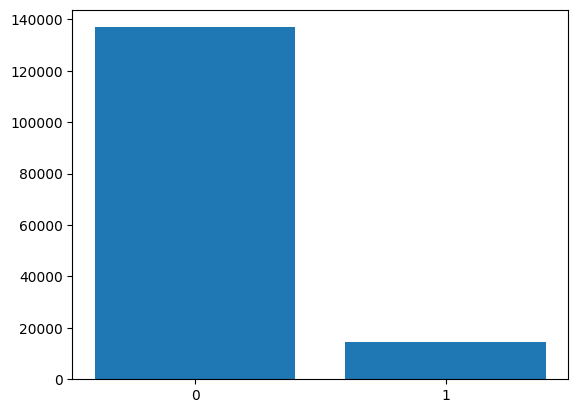

In [15]:
null_class_objs_count = (refacted_df['target'] == 0).sum()
first_class_objs_count = (refacted_df['target'] == 1).sum()
plt.figure()
plt.bar(['0', '1'], [null_class_objs_count, first_class_objs_count])



# Балансируем датасет

In [16]:
zero_target_df_part = refacted_df[refacted_df['target'] == 0].sample(n=first_class_objs_count, random_state=1)
# проверка 
ic(zero_target_df_part.shape)
ic((zero_target_df_part['target'] == 0).sum())
ic(first_class_objs_count)

ic| zero_target_df_part.shape: (14459, 26)
ic| (zero_target_df_part['target'] == 0).sum(): 14459
ic| first_class_objs_count: 14459


14459

Теперь супер важный момент - до этого я склеивал first_target_df_part c zero_target_df_part, но по хорошему их нужно премешивать! Иначе обучение будт происходит с избыточной законеомерностью - сначала идут пецики с 0-классом, а потом 1-классом 

In [17]:
first_target_df_part = refacted_df[refacted_df['target'] == 1]
balanced_df = pd.concat((zero_target_df_part, first_target_df_part), axis=0)
balanced_df = balanced_df.sample(n=2*zero_target_df_part.shape[0], random_state=1)
balanced_df.head()

,variable_1,variable_2,variable_4,variable_5,variable_6,variable_7,variable_8,variable_10,variable_11,variable_12,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target
18454,0.025491,0,0.036417,0.012802,0.021557,0.017904,0.0,0,0,0.037666,...,0.011508,0.025360,0.026575,0.000000,0.02429,0.0,0.020757,0.007422,0,1
120407,0.025491,0,0.030083,0.033073,0.010930,0.017904,0.0,0,0,0.031766,...,0.023016,0.029651,0.015596,0.088734,0.02429,0.0,0.020757,0.036596,0,0
56692,0.038237,0,0.017417,0.003201,0.019431,0.022558,0.0,0,0,0.018270,...,0.023016,0.021653,0.023703,0.000000,0.02429,0.0,0.020757,0.057952,0,0
10494,0.025491,0,0.036417,0.033073,0.004402,0.017904,0.0,0,0,0.037794,...,0.023016,0.029651,0.016833,0.088734,0.02429,0.0,0.020757,0.012391,0,0
149600,0.012746,0,0.028500,0.033073,0.010778,0.017904,0.0,0,0,0.029477,...,0.023016,0.029651,0.022024,0.088734,0.02429,0.0,0.020757,0.030285,0,0


Проверка

<BarContainer object of 2 artists>

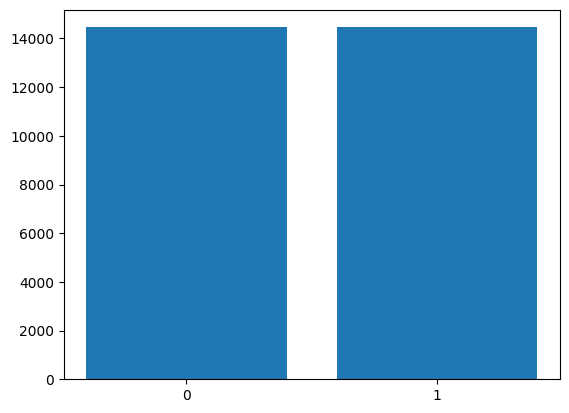

In [18]:
null_class_objs_count = (balanced_df['target'] == 0).sum()
first_class_objs_count = (balanced_df['target'] == 1).sum()
plt.figure()
plt.bar(['0', '1'], [null_class_objs_count, first_class_objs_count])

In [19]:
balanced_df.to_csv('balanced_df.csv', index=False)

# Разделяем датасет на learn и test части

##### Замечания
* Даже часть тестовых данных не должна вхолить в обучающую выборку => случайным семплированием я не обойдусь!
* Так как датасет несбалансирован, а после балансировки будет иметь всего лишь 28918 примеров

In [20]:
num_data_to_learn = balanced_df.shape[0] - TEST_DATA_NUM
num_data_to_learn

6294

Получается всего лишь 6294 примеров для обучения модели! Возможно этого и достаточно, но это кажется очень малым относительно исходного датасета!

In [21]:
learn_df = balanced_df.iloc[:num_data_to_learn]
test_df = balanced_df.iloc[num_data_to_learn:]
test_df.to_csv('insclass_test.csv', index=False)

# GD классификация

In [22]:
class LogisticRegressionGD(object):
    
    def __init__(self, is_rand_init: bool = True): 
        self.a = None
        self.is_rand_init = is_rand_init

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def predict(self, x, intercept: bool = False):
        if intercept is True:
            x_ = np.hstack((np.ones((x.shape[0],1)), x))
        else:
            x_ = x

        z = x_ @ self.a
        return self.sigmoid(z)

    def coefs(self):
        return self.a
    def LogLikelihood(self, x, Y):
        predict = self.predict(x)
        return -sum(Y * np.log2(predict) + (1 - Y) * np.log2(1 - predict)) / self.m
    def CrossEntropy(self, x, Y):
        return (-Y*np.log(self.predict(x)) - (1- Y)*np.log(1 - self.predict(x))).sum()

    def accuracy(self, x, Y, intercept: bool):
        x = x.copy()
        Y = Y.copy()
        
        if intercept:
            x = np.hstack((np.ones((x.shape[0], 1)), x))  
        
        predicts = self.predict(np.array(x))
        binary_predicts = np.rint(predicts)
        np_target = np.array(Y).reshape(x.shape[0], 1)

        compare_target_predict = binary_predicts == np_target
        num_right_answers = compare_target_predict.sum()

        accuracy = num_right_answers / np_target.shape[0]
        return accuracy
    
    def fit(self, x, Y, intercept: bool = True, alpha = 0.001, epsylon = 0.01, max_steps = 2500, Rtype = "LL"):
        
        x = x.copy()
        Y = Y.copy()

        if intercept:
            x = np.hstack((np.ones((x.shape[0], 1)), x))   
        
        if self.is_rand_init is True:
            self.a = np.random.rand(x.shape[1], 1)
        else:
            self.a = np.zeros(x.shape[1]).reshape(x.shape[1], 1)
        
        self.m = x.shape[0]
        
        x = np.array(x)
        Y = np.array(Y)
        Y = Y.reshape(Y.shape[0], 1)        # приводим адекватной форме для работы @ в numpy

        steps, errors = [], []
        step = 0
        for _ in range(max_steps):
            if Rtype == "LL":
                new_error = self.LogLikelihood(x, Y)
                dJ = x.T @ (self.predict(x) - Y) / self.m
                self.a -= alpha * dJ
            elif Rtype == "CE":
                raise Exception('TODO')
                # new_error = self.CrossEntropy(x, Y)
                # #display(new_error)
                # dT_a = -x.T @(Y - self.predict(x))
                # self.a -= alpha*dT_a
            step += 1
            steps.append(step)
            errors.append(new_error)
            if abs(new_error) < epsylon or len(steps) > max_steps:  # лучше использовать норму антиградиента
               break
        return steps, errors

# Обучение модели

In [23]:
X = learn_df.drop(['target'], axis=1)
Y = learn_df['target']

log_classification = LogisticRegressionGD(is_rand_init=False)
steps, errors = log_classification.fit(X, Y,  alpha = 2, epsylon = 0.1, max_steps = 800, Rtype = "LL")

array([0.9471894])

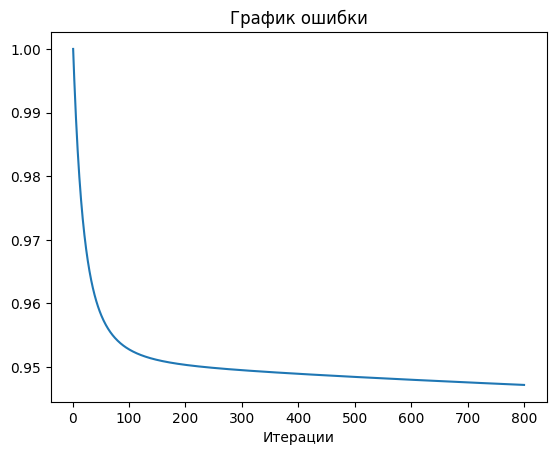

In [41]:
plt.figure()
plt.title('График ошибки')
plt.xlabel('Итерации')
plt.plot(steps, errors)
errors[-1]

# Тестируем обученную модель

Сравниваем полученные результаты классификации с истинными значениями классов

In [26]:
test_df = pd.read_csv('insclass_test.csv')
test_x = test_df.drop(['target'], axis=1)
log_classification.accuracy(x=test_x, Y=test_df['target'], intercept=True)


0.5659918670438473

f1 score

In [27]:
y_preidct = log_classification.predict(test_x, intercept=True)
binary_predicts = np.rint(y_preidct)
f1_score(y_true=test_df['target'], y_pred=binary_predicts)

0.34518172724241414

Протетсируем на данных сбалансированного датасета 

accuracy

In [28]:
x = learn_df.drop(['target'], axis=1)
log_classification.accuracy(x=x, Y=learn_df['target'], intercept=True)

0.5714966634890372

f1 score

In [29]:
y_preidct = log_classification.predict(learn_df.drop(['target'], axis=1), intercept=True)
binary_predicts = np.rint(y_preidct)
f1_score(y_true=learn_df['target'], y_pred=binary_predicts)

0.3502770416767044

Как видим точность сильно хуже !

# Попытка улучшить результат: обучение на большем количестве примеров

До этого обучающая выборка была меньше тестовой - кажется это не правильно! (Было сделано именно так из-за задания)
Разделим сбалансированный датасет иначе! Теперь TEST_DATA_NUM - это кол-во примеров обучающей выборки.

In [37]:
num_data_to_learn = TEST_DATA_NUM

learn_df_imp = balanced_df.iloc[:num_data_to_learn]
test_df_imp = balanced_df.iloc[num_data_to_learn:]

,variable_1,variable_2,variable_4,variable_5,variable_6,variable_7,variable_8,variable_10,variable_11,variable_12,...,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,target
82389,0.012746,0,0.028500,0.033073,0.013207,0.017904,0.000000,0,0,0.030424,...,0.023016,0.031797,0.032119,0.000000,0.02429,0.0,0.020757,0.020619,0,1
61959,0.006373,0,0.011083,0.024538,0.015333,0.013424,0.017904,0,0,0.010970,...,0.000000,0.023214,0.032362,0.000000,0.02429,0.0,0.020757,0.030285,0,0
106704,0.025491,0,0.004750,0.024538,0.018672,0.015266,0.017904,1,0,0.017904,...,0.011508,0.004487,0.016082,0.000000,0.02429,0.0,0.000000,0.012391,0,1
17104,0.006373,0,0.026917,0.012802,0.015940,0.018807,0.000000,0,0,0.028250,...,0.023016,0.017947,0.006804,0.000000,0.02429,0.0,0.020757,0.009076,0,1
83790,0.025491,0,0.003167,0.007468,0.016699,0.017904,0.000000,0,0,0.000000,...,0.011508,0.023409,0.009786,0.000000,0.00000,0.0,0.020757,0.015698,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34686,0.019118,0,0.012667,0.007468,0.013055,0.017904,0.000000,0,0,0.013212,...,0.023016,0.023409,0.004020,0.000000,0.00000,0.0,0.020757,0.022247,0,0
30130,0.031864,0,0.015833,0.012802,0.016243,0.017904,0.000000,0,0,0.016918,...,0.023016,0.017947,0.027171,0.000000,0.02429,0.0,0.020757,0.020619,0,1
108880,0.012746,0,0.011083,0.038407,0.017610,0.017233,0.000000,0,0,0.010480,...,0.023016,0.002341,0.023195,0.000000,0.00000,0.0,0.020757,0.012391,0,0
58574,0.025491,0,0.023750,0.001067,0.011386,0.011505,0.000000,0,0,0.025342,...,0.023016,0.000195,0.000022,0.000000,0.02429,0.0,0.020757,0.025482,0,0


In [38]:
X = learn_df_imp.drop(['target'], axis=1)
Y = learn_df_imp['target']

log_classification = LogisticRegressionGD(is_rand_init=False)
steps, errors = log_classification.fit(X, Y,  alpha = 2, epsylon = 0.1, max_steps = 800, Rtype = "LL")

ic| errors[-1]: array([0.9471894])


array([0.9471894])

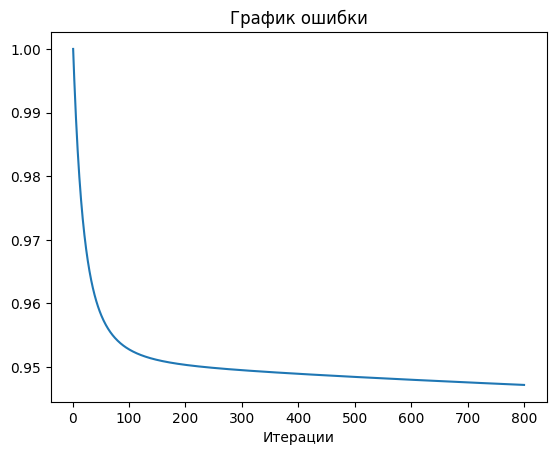

In [40]:
plt.figure()
plt.title('График ошибки')
plt.xlabel('Итерации')
plt.plot(steps, errors)
ic(errors[-1])

В предыдущем случае получили ошибку 0.94860071, теперь 0.9471894 - это ничтожно малое отличие

In [42]:
test_x = test_df_imp.drop(['target'], axis=1)
log_classification.accuracy(x=test_x, Y=test_df_imp['target'], intercept=True)

0.5653002859866539

# SGD классификация

In [31]:
class BinaryClassificationSGD:
    def __init__(self, lr=0.01, max_iter=1000, batch_size=32, tol=1e-3, intercept = True):
        # скорость обучения градиентного спуска
        self.learning_rate = lr 
        # максимальное число итераций
        self.max_iteration = max_iter 
        # размер мини-батча 
        self.batch_size = batch_size  
        # критерий сходимости  
        self.tolerance_convergence  = tol
        # наличие свободного члена
        self.intercept = intercept
        # инициальзация весов: None
        self.theta = None
        self.n = None
        self.d = None
         
    def accuracy(self, x, Y):
        x = x.copy()
        Y = Y.copy()
        
        predicts = self.predict(np.array(x))
        binary_predicts = np.rint(predicts).reshape(x.shape[0], 1)
        np_target = np.array(Y).reshape(x.shape[0], 1)

        compare_target_predict = binary_predicts == np_target
        num_right_answers = compare_target_predict.sum()

        accuracy = num_right_answers / np_target.shape[0]
        return accuracy
    
    def fit(self, X, y):
        self.X = np.array(X.copy())
        self.y = np.array(y.copy())
        if self.intercept:
            self.X = np.hstack((np.ones((self.X.shape[0], 1)), self.X))   
        # размерность вектора X 
        self.n, self.d = self.X.shape
        # инициализация случайных весов
        self.theta = np.random.randn(self.d)
        steps, errors = [], []
        step = 0
        for _ in range(self.max_iteration):
            # перемешивание данных
            indices = np.random.permutation(self.n)
            X = self.X[indices]
            y = self.y[indices]
            # цикл по мини-батчам
            for i in range(0, self.n, self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y[i:i+self.batch_size]
                grad = self.gradient(X_batch, y_batch)
                self.theta -= self.learning_rate * grad
            new_error = ((self.y - self.X @ self.theta).T @ (self.y - self.X @ self.theta)) / self.n
            step += 1
            steps.append(step)
            errors.append(new_error)
            # проверка сходимости
            if np.linalg.norm(grad) < self.tolerance_convergence:
                break
        return steps, errors
    
    def gradient(self, X, y):
        return X.T @ (X @ self.theta - y) / len(y)
             
    def predict(self, X):
        if self.intercept:
            X_ = np.hstack((np.ones((X.shape[0],1)), X))
        else:
            X_ = X
        z = X_ @ self.theta
        return 1 / (1 + np.exp(-z))

    def MSE(self, X, y):
        return ((y - self.predict(X)).T @ (y - self.predict(X))) / len(y)
    
    def MAE(self, X, y):
        return abs(y - self.predict(X)).mean()
    
    def MAPE(self, X, y):
        return abs((y - self.predict(X))/y).mean()


In [32]:
sgd_classificator = BinaryClassificationSGD(max_iter=800)
steps, errors = sgd_classificator.fit(X=learn_df.drop(['target'], axis=1), y=learn_df['target'])

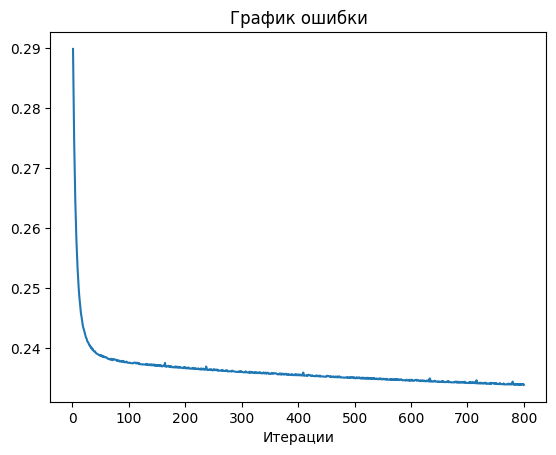

In [33]:
plt.figure()
plt.title('График ошибки')
plt.xlabel('Итерации')
plt.plot(steps, errors)

In [34]:

y_preidct = sgd_classificator.predict(test_df.drop(['target'], axis=1))
binary_predicts = np.rint(y_preidct)
f1_score(y_true=test_df['target'], y_pred=binary_predicts)

0.6678051940403981

In [35]:
 
y_preidct = sgd_classificator.predict(learn_df.drop(['target'], axis=1))
binary_predicts = np.rint(y_preidct)
f1_score(y_true=learn_df['target'], y_pred=binary_predicts)

0.6627005205566769

In [36]:

sgd_classificator.accuracy(x=test_x, Y=test_df['target'])


0.5013260254596889